In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import shutil
from base64 import b64encode
from PIL import Image

import numpy as np
import torch
import torch.nn.functional as F
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel, StableDiffusionPipeline
from IPython.display import HTML
from matplotlib import pyplot as plt
from tqdm import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging, CLIPImageProcessor, CLIPVisionModelWithProjection


from constants import UNCONDITIONAL_DIFFUSION_MODEL_REPO, DIFFUSION_MODEL_REPO, CLIP_MODEL_REPO, TMP_FOLDER_PATH, MODEL_FOLDER_PATH, IMAGE_FOLDER_PATH, CUDA_DEVICE, TEXT_TO_IMAGE_PROMPTS
from utils import image_grid, encode_image, decode_image, encode_text

__This notebook is adapted from https://github.com/fastai/diffusion-nbs/blob/master/Stable%20Diffusion%20Deep%20Dive.ipynb__

### Load models

In [3]:
# variational autoencoder
vae = AutoencoderKL.from_pretrained(DIFFUSION_MODEL_REPO, subfolder="vae", cache_dir=MODEL_FOLDER_PATH)

# CLIP
tokenizer = CLIPTokenizer.from_pretrained(CLIP_MODEL_REPO, cache_dir=MODEL_FOLDER_PATH)
text_encoder = CLIPTextModel.from_pretrained(CLIP_MODEL_REPO, cache_dir=MODEL_FOLDER_PATH)

# UNet
unet = UNet2DConditionModel.from_pretrained(DIFFUSION_MODEL_REPO, subfolder="unet", cache_dir=MODEL_FOLDER_PATH)

# noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# diffusion pipeline
pipe = StableDiffusionPipeline.from_pretrained(DIFFUSION_MODEL_REPO, cache_dir=MODEL_FOLDER_PATH)

# load models to device
pipe = pipe.to(CUDA_DEVICE)
vae = vae.to(CUDA_DEVICE)
text_encoder = text_encoder.to(CUDA_DEVICE)
unet = unet.to(CUDA_DEVICE);

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


# 1. Encoder

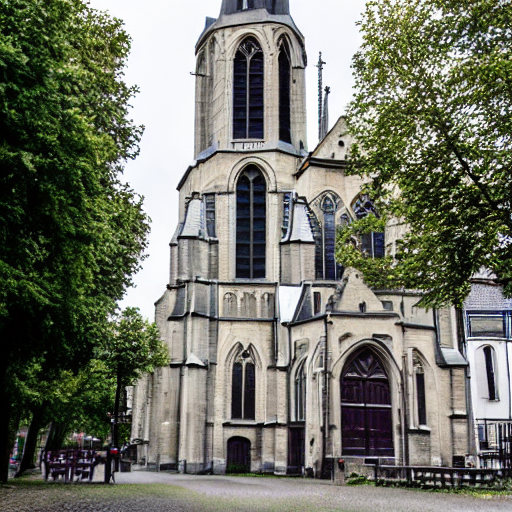

In [4]:
image = Image.open(IMAGE_FOLDER_PATH / "2.an_image_of_church_in_ghent.png")
image

torch.Size([1, 4, 64, 64])


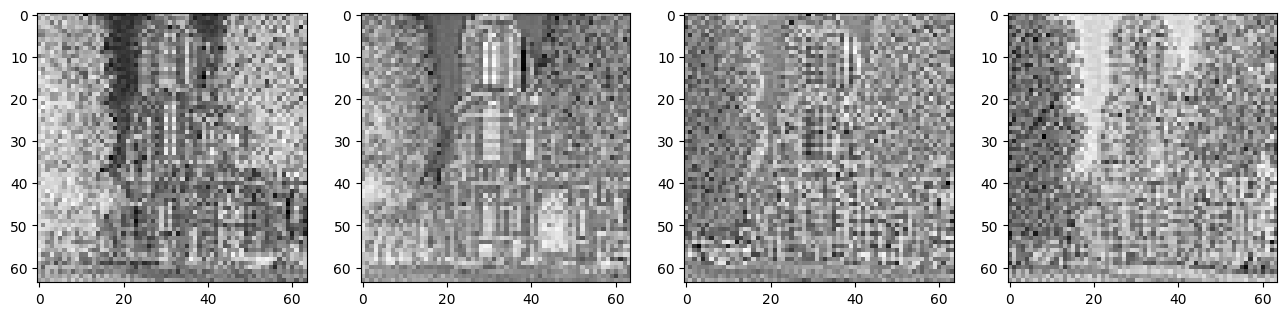

In [5]:
latents = encode_image(image, vae)
print(latents.shape)

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(latents[0][c].cpu(), cmap='Greys')

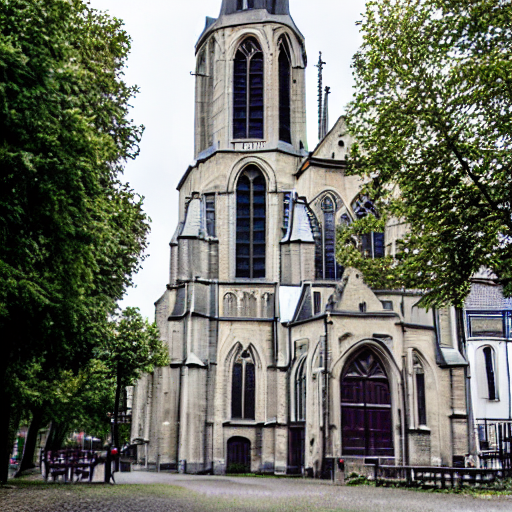

In [6]:
decode_image(latents, vae)[0]

## Decode intermediate step

/home/bkang/ugent_generative_ai_course/code/lecture-03/ugenai3/lib/python3.8/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:736: FutureWarning: `callback` is deprecated and will be removed in version 1.0.0. Passing `callback` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`
  deprecate(
/home/bkang/ugent_generative_ai_course/code/lecture-03/ugenai3/lib/python3.8/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:742: FutureWarning: `callback_steps` is deprecated and will be removed in version 1.0.0. Passing `callback_steps` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`
  deprecate(


  0%|          | 0/50 [00:00<?, ?it/s]

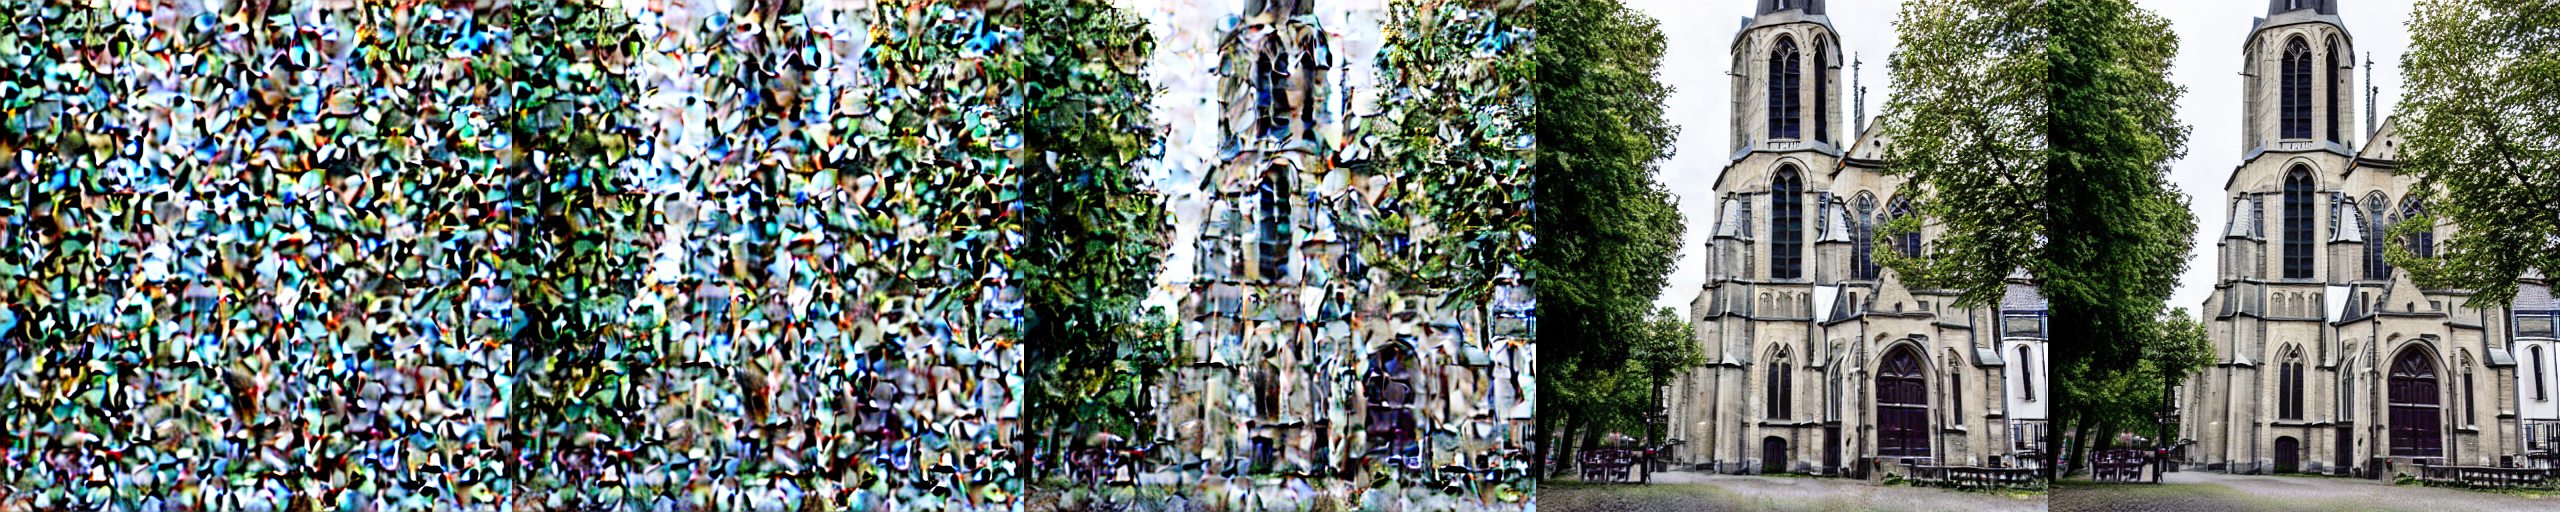

In [7]:
images = []

def latents_callback(i, t, latents):
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents).sample[0]
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(1, 2, 0).numpy()
    images.extend(pipe.numpy_to_pil(image))

prompt = TEXT_TO_IMAGE_PROMPTS[0]
torch.manual_seed(0)
final_image = pipe(prompt, callback=latents_callback, callback_steps=12).images[0]
images.append(final_image)
image_grid(images, rows=1, cols=len(images))

# 2. CLIP

In [8]:
text_to_image_prompts = TEXT_TO_IMAGE_PROMPTS + ["An image of a bridge in Ghent"]
text_input = tokenizer(text_to_image_prompts, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input["input_ids"].shape

torch.Size([4, 77])

In [9]:
output_embeddings = text_encoder(text_input.input_ids.to(CUDA_DEVICE))[0]
print('Shape:', output_embeddings.shape)

Shape: torch.Size([4, 77, 768])


In [10]:
with torch.no_grad():
    attention_mask = text_input["attention_mask"].to(CUDA_DEVICE)
    text_embeddings = ((output_embeddings * attention_mask.unsqueeze(-1)).sum(1) / attention_mask.sum(1).unsqueeze(1)).cpu()
    normed_embeddings = F.normalize(text_embeddings, p=2, dim=1)
    similarity_matrix = torch.mm(normed_embeddings, normed_embeddings.transpose(0, 1)).numpy()

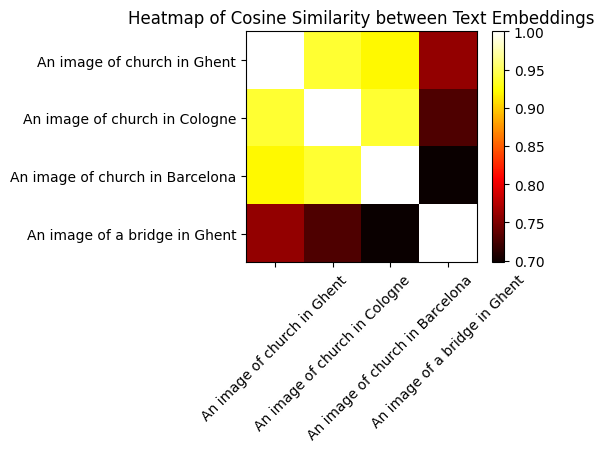

In [11]:
# Plot the heatmap
plt.figure(figsize=(4, 3))
plt.imshow(similarity_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()

# Add title and labels if needed
plt.title('Heatmap of Cosine Similarity between Text Embeddings')
# plt.xlabel('Text Embeddings')
# plt.ylabel('Text Embeddings')

# Optionally, add tick labels
tick_labels = text_to_image_prompts
plt.xticks(np.arange(len(tick_labels)), tick_labels, rotation=45)
plt.yticks(np.arange(len(tick_labels)), tick_labels)

plt.show()

In [12]:
image_processor = CLIPImageProcessor.from_pretrained(CLIP_MODEL_REPO, cache_dir=MODEL_FOLDER_PATH)
image_encoder = CLIPVisionModelWithProjection.from_pretrained(CLIP_MODEL_REPO, cache_dir=MODEL_FOLDER_PATH).to(CUDA_DEVICE)

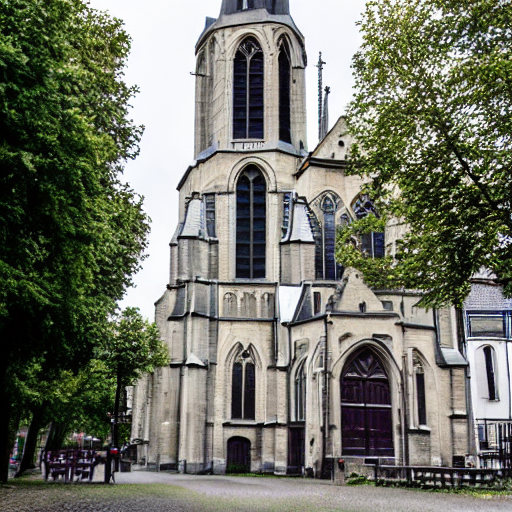

In [13]:
image = Image.open(IMAGE_FOLDER_PATH / "2.an_image_of_church_in_ghent.png")
image

In [14]:
with torch.no_grad():    
    preprocessed_image = image_processor(image, return_tensors="pt")["pixel_values"].to(CUDA_DEVICE)
    image_features = image_encoder(pixel_values=preprocessed_image).image_embeds.cpu()
    image_features = image_features / image_features.norm(dim=1, keepdim=True)
    image_features = F.normalize(image_features, p=2, dim=1)
    similarity_matrix = torch.mm(image_features, text_embeddings.transpose(0, 1))

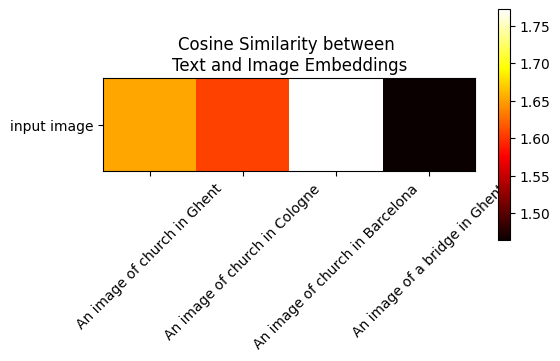

In [15]:
# Plot the heatmap
plt.figure(figsize=(6, 3))
plt.imshow(similarity_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()

# Add title and labels if needed
plt.title('Cosine Similarity between \nText and Image Embeddings')
# plt.xlabel('Text Embeddings')
# plt.ylabel('Text Embeddings')

# Optionally, add tick labels
x_tick_labels = text_to_image_prompts
plt.xticks(np.arange(len(x_tick_labels)), x_tick_labels, rotation=45)
plt.yticks([0], ["input image"])

plt.show()

# 3. Scheduler

In [16]:
num_inferences_steps=50
scheduler.set_timesteps(num_inferences_steps)

In [17]:
scheduler.timesteps

tensor([999.0000, 978.6122, 958.2245, 937.8367, 917.4490, 897.0612, 876.6735,
        856.2857, 835.8979, 815.5102, 795.1224, 774.7347, 754.3469, 733.9592,
        713.5714, 693.1837, 672.7959, 652.4081, 632.0204, 611.6326, 591.2449,
        570.8571, 550.4694, 530.0816, 509.6939, 489.3061, 468.9184, 448.5306,
        428.1429, 407.7551, 387.3673, 366.9796, 346.5918, 326.2041, 305.8163,
        285.4286, 265.0408, 244.6531, 224.2653, 203.8775, 183.4898, 163.1020,
        142.7143, 122.3265, 101.9388,  81.5510,  61.1633,  40.7755,  20.3878,
          0.0000])

In [18]:
scheduler.sigmas

tensor([14.6146, 12.9368, 11.4916, 10.2429,  9.1604,  8.2187,  7.3972,  6.6780,
         6.0465,  5.4903,  4.9989,  4.5633,  4.1761,  3.8308,  3.5221,  3.2451,
         2.9958,  2.7709,  2.5673,  2.3825,  2.2143,  2.0606,  1.9199,  1.7907,
         1.6716,  1.5617,  1.4598,  1.3651,  1.2768,  1.1944,  1.1171,  1.0444,
         0.9759,  0.9112,  0.8497,  0.7913,  0.7355,  0.6820,  0.6306,  0.5809,
         0.5328,  0.4858,  0.4397,  0.3940,  0.3483,  0.3019,  0.2535,  0.2012,
         0.1393,  0.0292,  0.0000])

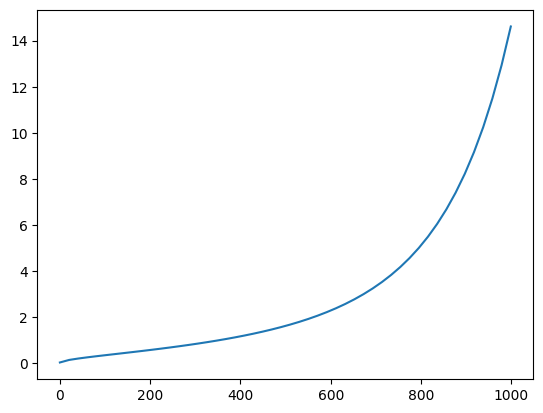

In [19]:
plt.plot(scheduler.timesteps, scheduler.sigmas[:-1]);

# 4. Reverse Diffusion Loop 
with U-Net

In [20]:
# ??unet.forward

In [21]:
# ??scheduler.step

In [22]:
# set parameters
prompt = TEXT_TO_IMAGE_PROMPTS[0]
height = 512
width = 512
num_inference_steps = 50
guidance_scale = 8
generator = torch.manual_seed(0)
batch_size = 1

# Make a folder to store results
output_folder_path = IMAGE_FOLDER_PATH / "unet_steps"
shutil.rmtree(output_folder_path, ignore_errors=True)
output_folder_path.mkdir(exist_ok=True)


# Text Embeddings
# prompt: 'An image of church in Ghent'
text_embeddings = encode_text([prompt], tokenizer, text_encoder)
uncond_embeddings = encode_text([""] * batch_size, tokenizer, text_encoder, max_length=text_embeddings.shape[1])
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Set scheduler steps
scheduler.set_timesteps(num_inference_steps)

# Initialize latents
latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator,)
latents = latents.to(CUDA_DEVICE)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)    
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # predict the original and previous sample
    scheduler_step_output = scheduler.step(noise_pred, t, latents)
    latents_x0 = scheduler_step_output.pred_original_sample    
    latents = scheduler_step_output.prev_sample

    # To PIL Images
    im_t0 = decode_image(latents_x0, vae)[0]
    im_next = decode_image(latents, vae)[0]

    # Combine the two images and save for later viewing
    im = Image.new('RGB', (1024, 512))
    im.paste(im_next, (0, 0))
    im.paste(im_t0, (512, 0))
    im.save(output_folder_path / f'{i:04}.jpeg')

/tmp/ipykernel_25563/2972961787.py:26: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator,)
100%|██████████| 50/50 [00:18<00:00,  2.72it/s]


In [24]:

!ffmpeg -v 1 -y -f image2 -framerate 12 -i ./tmp/images/unet_steps/%04d.jpeg -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out.mp4
mp4 = open('out.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1024 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)